In [1612]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV

In [1614]:
# CLEANING DATA 

# Load the dataset from the GitHub repository
url = "https://github.com/kristenauriemma/595Project/raw/main/USvideos.csv"
df = pd.read_csv(url)
print(df.head())

# Convert 'trending_date' to datetime format (DD.MM.YY)
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%d.%m.%y', errors='coerce')

# Drop rows with invalid 'trending_date' but keep those with valid views
df = df.dropna(subset=['trending_date'])
# Drop rows with missing 'video_id'
df = df.dropna(subset=['video_id'])
# Drop duplicates
df = df.drop_duplicates()


# Ensure 'views' is numeric and remove rows where 'views' is NaN
df['views'] = pd.to_numeric(df['views'], errors='coerce')
df = df.dropna(subset=['views'])  # Drop rows where 'views' is NaN

# Handle missing values in other columns
numeric_columns = df.select_dtypes(include=['number']).columns

# Fill missing numeric columns with the mean
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Convert 'category_id' to category type (if you plan to use this in models)
df['category_id'] = df['category_id'].astype('category')

# Reset index
df = df.reset_index(drop=True)


      video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  1ZAPwfrtAFY      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  puqaWrEC7tY      17.14.11   
4  d380meD0W0M      17.14.11   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

   category_id              publish_time  \
0           22  2017-11-13T17:13:01.000Z   
1           24  2017-11-13T07:30:00.000Z   
2           23  2017-11-12T19:05:24.000Z   
3           24  2017-11-13T11:00:04.000Z   
4           24  2017-11-12T18:01:41.000Z   

                                                tags    views   lik

In [1615]:
# PREPARING & PROCESSING DATA

# Create a 7-day moving average of views
df['views_7d_avg'] = df.groupby('video_id')['views'].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)
df['views_7d_avg'].fillna(0)

# Verify if the new feature has been added correctly
print(df[['video_id', 'trending_date', 'views', 'views_7d_avg']].head())

# Split the data into features (X) and target (y)
X = df.drop(columns=['views'])  # Features (drop the target column 'views')
y = df['views']  # Target variable (views)

# Ensure proper formatting
# Convert 'publish_time' and 'trending_date' to datetime
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce').dt.tz_localize(None)
df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce').dt.tz_localize(None)

# Create new features
df['publish_hour'] = df['publish_time'].dt.hour  # Extract the hour of the day the video was published
df['publish_weekday'] = df['publish_time'].dt.weekday  # 0=Monday, 6=Sunday
df['publish_month'] = df['publish_time'].dt.month  # Extract the month the video was published
df['publish_week'] = df['publish_time'].dt.isocalendar().week  # Week of the year

df['days_since_publish'] = (df['trending_date'] - df['publish_time']).dt.days  # Number of days since the video was published

df = df.dropna(subset=['publish_time', 'days_since_publish'])

# Handle categorical features 
df = pd.get_dummies(df, columns=['category_id'], drop_first=True)


      video_id trending_date     views  views_7d_avg
0  6ZfuNTqbHE8    2012-01-17  56367282    56367282.0
1  nx1R-eHSkfM    2012-01-17   1894443     1894443.0
2  XbuQAbG2AZ0    2012-01-17    224270      224270.0
3  evhLzq7Gsak    2012-01-17   1717225     1717225.0
4  KXHrCBkIxQQ    2012-01-17    616077      616077.0


In [1616]:
# SPLITTING THE DATASET

# Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop categorical columns (e.g., video_id, title, etc.) 
columns_to_drop = ['video_id', 'title', 'channel_title', 'tags', 'description']
X_train = X_train.drop(columns=[col for col in columns_to_drop if col in X_train.columns])
X_test = X_test.drop(columns=[col for col in columns_to_drop if col in X_test.columns])

In [1617]:
# PREPROCESSING DATA

# Select numeric columns after dropping categorical columns
X_train = X_train.select_dtypes(include=['float64', 'int64'])
X_test = X_test.select_dtypes(include=['float64', 'int64'])

# Handle missing values for both training and testing datasets
X_train = X_train.fillna(X_train.mean())  # Fill missing values in training data
X_test = X_test.fillna(X_test.mean())    # Fill missing values in testing data

In [1618]:
# SCALING DATA

# Scale the data using the same scaler for both training and testing datasets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform X_train
X_test_scaled = scaler.transform(X_test)  # Only transform X_test

# Print out the shapes of the training and testing sets
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 12300 samples
Testing set size: 3075 samples


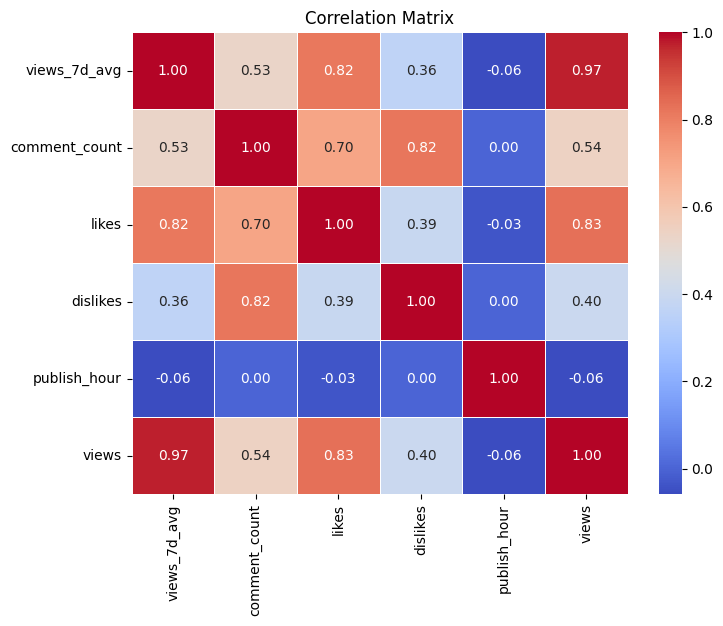

Correlation between views_7d_avg and views: 0.974
Correlation between comment_count and views: 0.543
Correlation between likes and views: 0.832
Correlation between dislikes and views: 0.398
Correlation between publish_hour and views: -0.059


In [1619]:
# CORRELATION CALCULATION
# Numeric columns for correlation calculation
numeric_features = ['views_7d_avg','comment_count', 'likes', 'dislikes', 'publish_hour', 'views']

# Calculate correlation matrix for selected numeric features
correlation_scores = df[numeric_features].corr()

# CORRELATION VISUALIZATION
# Display the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_scores, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Print the individual correlations with views
for feature in numeric_features:
    if feature != 'views':  # Don't calculate correlation for the target itself
        correlation_score = df[feature].corr(df['views'])
        print(f"Correlation between {feature} and views: {correlation_score:.3f}")


##### 7-day moving average of views (views_7d_avg): This variable shows a very strong positive relationship with views, indicating that past performance is a key predictor for future views. Videos that have been performing well recently are likely to continue attracting more views.

##### Comments (comment_count): There is a moderate positive correlation with views, suggesting that as videos gain more views, they also tend to receive more comments. However, other factors could also influence the number of comments, indicating that comments are somewhat tied to views, but not as strongly as other engagement metrics like likes.

##### Likes: A strong positive relationship with views indicates that higher engagement (through likes) is strongly linked to a video’s success. Videos with more likes tend to have more views, signaling that popular videos are generally more liked by viewers.

##### Dislikes: While there is a weaker positive correlation with views, dislikes have a lesser impact on predicting views compared to likes and comments. Dislikes may indicate polarizing content, but they don't appear to be a major factor in driving the view count.

##### Publish hour (publish_hour): The correlation with views is very weak, suggesting that the time of day when a video is published has little to no impact on its total views. Other factors, such as content quality or engagement, are likely more important than the timing of publication.

In [1621]:
# UNTUNED LINEAR REGRESSION

# Create and fit Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions with the Linear Regression model
lr_pred = lr_model.predict(X_test_scaled)

# Evaluate the Linear Regression model
lr_mse = mean_squared_error(y_test, lr_pred)  # Mean Squared Error (MSE)
lr_r2 = r2_score(y_test, lr_pred)  # R-squared score
lr_mae = mean_absolute_error(y_test, lr_pred)  # Mean Absolute Error (MAE)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred)) # Root MSE

# MODEL WITH FEATURE COEFFICIENTS
# Create and fit the model using scaled data
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

# PERFORMANCE
print("Untuned Linear Regression MSE:", lr_mse)
print("Untuned Linear Regression R²:", lr_r2)
print("Untuned Linear Regression MAE:", lr_mae)
print("Untuned Linear Regression RMSE:", lr_rmse)

Untuned Linear Regression MSE: 1189158875900.398
Untuned Linear Regression R²: 0.9705650660864205
Untuned Linear Regression MAE: 388334.55286277
Untuned Linear Regression RMSE: 1090485.6147150213


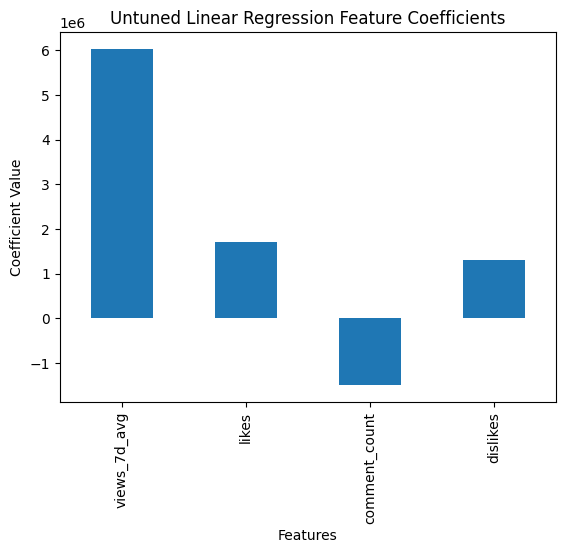

In [1622]:
# UNTUNED LINEAR REGRESSION FEATURE COEFFICIENT PLOT

# Display feature importance (coefficients)
coefficients = pd.DataFrame(model_lr.coef_, X_train.columns, columns=['Coefficient'])
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()  
coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)

# Linear Regression Coefficients Plot
coefficients['Coefficient'].plot(kind='bar')
plt.title('Untuned Linear Regression Feature Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

##### 7-Day Average Views: The views_7day_avg feature has the highest coefficient, significantly outpacing others, indicating it is the strongest predictor of total views. This metric captures recent engagement, showing that videos consistently attracting views over the past week are highly likely to continue trending.

##### Likes: Although less impactful than the 7-day average, likes are still a substantial factor in view count prediction, with a positive but smaller coefficient. High like counts are a strong indication of popularity and positive reception, both of which contribute meaningfully to overall views.

##### Dislikes: Dislikes show a smaller positive correlation with view count. This suggests that polarizing content, which gains more dislikes, may still drive viewer curiosity and engagement.

##### Comment Count: Comments also contribute to view predictions but to a lesser degree. Engagement through comments signals active interaction but does not influence view count as strongly as likes, dislikes, or recent view trends.

##### Publish Time: Publish time had minimal correlation with views, suggesting that timing alone does not strongly influence a video’s popularity or its potential to trend.

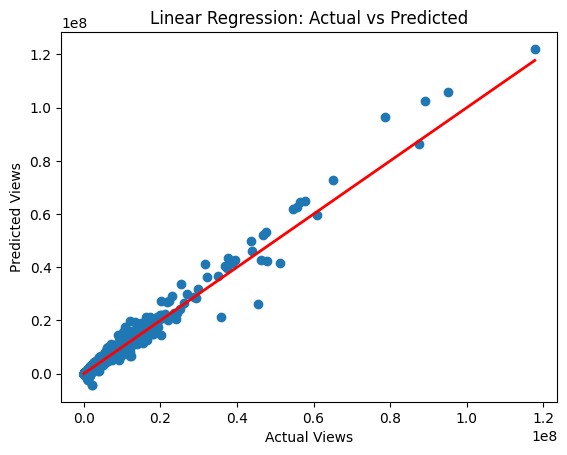

In [1624]:
# UNTUNED PREDICTED VS. ACTUAL FOR LINEAR REGRESSION

# Predicted vs Actual for Linear Regression
plt.scatter(y_test, lr_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.show()

In [1625]:
# LINEAR REGRESSION TUNING - RIDGE REGRESSION 

# Set up the parameter grid for Ridge regression (regularized Linear Regression)
param_grid_lr = {
    'alpha': [0.1, 1, 10, 100]  # Regularization strength
}

# Perform GridSearchCV for Linear Regression (Ridge)
grid_search_lr = GridSearchCV(Ridge(), param_grid_lr, cv=5, scoring='neg_mean_squared_error')
grid_search_lr.fit(X_train_scaled, y_train)

# PERFORMANCE
# Get the best parameters
print("Best parameters for Linear Regression:", grid_search_lr.best_params_)

# Evaluate the best Ridge model
best_lr_model = grid_search_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test_scaled)

# Recalculate MSE and R² for the tuned model
lr_mse_tuned = mean_squared_error(y_test, y_pred_lr)
lr_r2_tuned = r2_score(y_test, y_pred_lr)
lr_mae_tuned = mean_absolute_error(y_test, y_pred_lr)  
lr_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_lr)) 
print("Tuned Linear Regression MSE:", lr_mse_tuned)
print("Tuned Linear Regression R²:", lr_r2_tuned)
print("Tuned Linear Regression MAE:", lr_mae_tuned)
print("Tuned Linear Regression RMSE:", lr_rmse_tuned)

Best parameters for Linear Regression: {'alpha': 10}
Tuned Linear Regression MSE: 1184548793662.2175
Tuned Linear Regression R²: 0.9706791782280081
Tuned Linear Regression MAE: 387203.99727629713
Tuned Linear Regression RMSE: 1088369.787187341


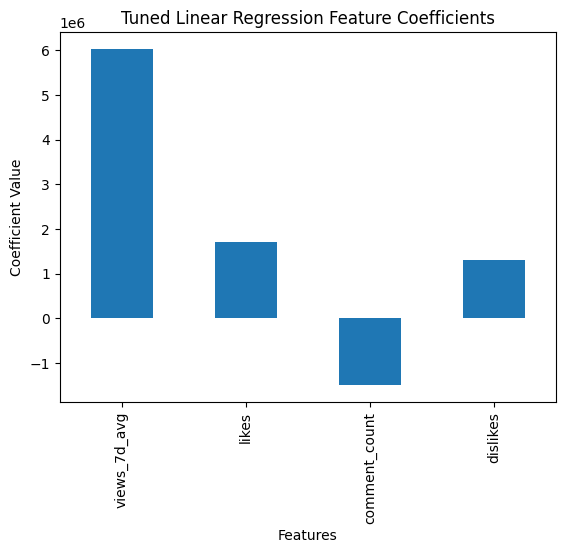

In [1626]:
# TUNED LINEAR REGRESSION FEATURE COEFFICIENT PLOT

# Get Feature Coefficients from Tuned Model
coefficients_tuned = pd.DataFrame(best_lr_model.coef_, X_train.columns, columns=['Coefficient'])
coefficients_tuned['Abs_Coefficient'] = coefficients_tuned['Coefficient'].abs()
coefficients_tuned = coefficients_tuned.sort_values(by='Abs_Coefficient', ascending=False)

# Plot Coefficients 
coefficients['Coefficient'].plot(kind='bar')
plt.title('Tuned Linear Regression Feature Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

##### The tuned coefficients largely mirror the untuned results in terms of feature importance and relationships. The 7-day average views remain the dominant predictor, followed by likes, dislikes, and comments, with minimal changes in their relative impact. 

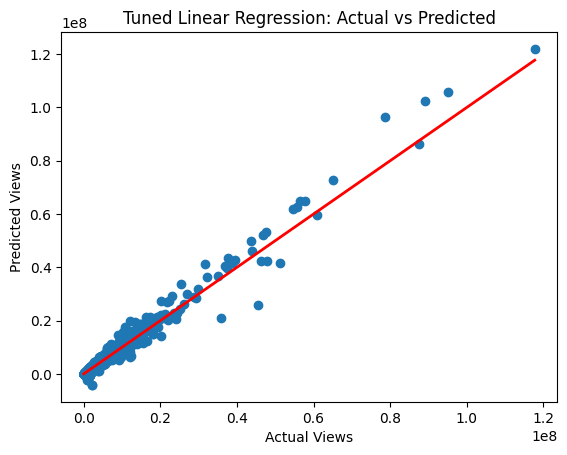

In [1628]:
# TUNED PREDICTED VS. ACTUALFOR LINEAR REGRESSION

# Recalculate predictions for tuned model
lr_pred_tuned = best_lr_model.predict(X_test_scaled)

# Reprint Predicted vs Actual for tuned Linear Regression
plt.scatter(y_test, lr_pred_tuned)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.title('Tuned Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.show()

In [1629]:
# UNTUNED XGBOOST

# Create and fit an XGBoost model
xg_model = xgb.XGBRegressor()
xg_model.fit(X_train_scaled, y_train)

# Make predictions with the XGBoost model
xg_pred = xg_model.predict(X_test_scaled)

# Evaluate the XGBoost model
xg_mse = mean_squared_error(y_test, xg_pred)  # Mean Squared Error (MSE)
xg_r2 = r2_score(y_test, xg_pred)  # R-squared score
xg_mae = mean_absolute_error(y_test, xg_pred) # Mean Absolute Error (MAE)
xg_rmse = np.sqrt(mean_squared_error(y_test, xg_pred)) # Root MSE

# MODEL WITH FEATURE IMPORTANCE
# Fit the model
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)

# PERFORMANCE
# XGBoost
print(f"Untuned XGBoost MSE: {xg_mse}")
print(f"Untuned XGBoost R²: {xg_r2}")
print(f"Untuned XGBoost MAE: {xg_mae}")
print(f"Untuned XGBoost RMSE: {xg_rmse}")

Untuned XGBoost MSE: 2147052363602.9229
Untuned XGBoost R²: 0.9468545829220719
Untuned XGBoost MAE: 226711.3243938961
Untuned XGBoost RMSE: 1465282.3494476834


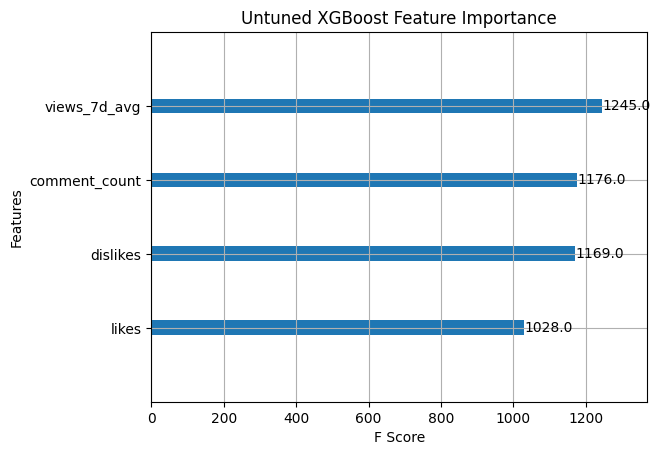

In [1630]:
# UNTUNED XGBOOST FEATURE IMPORTANCE PLOT

# Plot feature importance
plot_importance(model_xgb, importance_type='weight')
plt.yticks(ticks=range(len(X_train.columns)), labels=X_train.columns)
plt.title('Untuned XGBoost Feature Importance')
plt.xlabel('F Score')
plt.ylabel('Features')
plt.show()  # Display the plot

##### Views 7-Day Average is the most influential feature in predicting view count. Its high importance in XGBoost demonstrates that recent viewing trends are a critical factor in estimating a video's future popularity.

##### Comments follow as the next most impactful feature. While not as dominant as the 7-day view average, they still indicate active viewer interaction and engagement, contributing significantly to predicting success.

##### Dislikes also holds importance, comparable to comments. This suggests that negative reactions, though traditionally seen as unfavorable, can still reflect heightened viewer interest and engagement.

##### Likes contribute to the prediction by highlighting viewer approval. Videos with more likes often generate additional interest. This indicates that both positive and negative audience reactions play a role in engagement, though likes have a smaller overall effect compared to other key features.

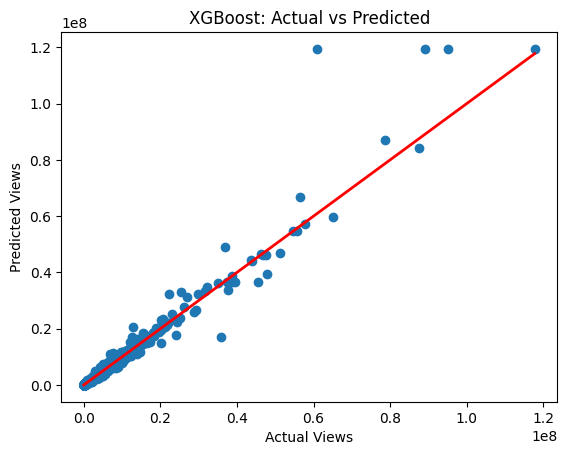

In [1632]:
# UNTUNED PREDICTED VS. ACTUAL FOR XGBOOST

# Predicted vs Actual for XGBoost
plt.scatter(y_test, xg_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.show()


In [1633]:
# XGBOOST - HYPERPARAMATER TUNING 

# Set up the parameter grid for XGBoost
param_grid_xgb = {
     'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'subsample': [0.8, 1.0]
}

# Perform GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(xgb.XGBRegressor(), param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train_scaled, y_train)

# PERFORMANCE
# Get the best parameters
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

# Evaluate the best XGBoost model
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

# Recalculate MSE and R² for the tuned model
xg_mse_tuned = mean_squared_error(y_test, y_pred_xgb)
xg_r2_tuned = r2_score(y_test, y_pred_xgb)
xg_mae_tuned = mean_absolute_error(y_test, y_pred_xgb)
xg_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("Tuned XGBoost MSE:", xg_mse_tuned)
print("Tuned XGBoost R²:", xg_r2_tuned)
print("Tuned XGBoost MAE:", xg_mae_tuned)
print("Tuned XGBoost RMSE:", xg_rmse_tuned)

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
Tuned XGBoost MSE: 2356839933775.4546
Tuned XGBoost R²: 0.941661766899702
Tuned XGBoost MAE: 252840.24581491362
Tuned XGBoost RMSE: 1535200.2910941148


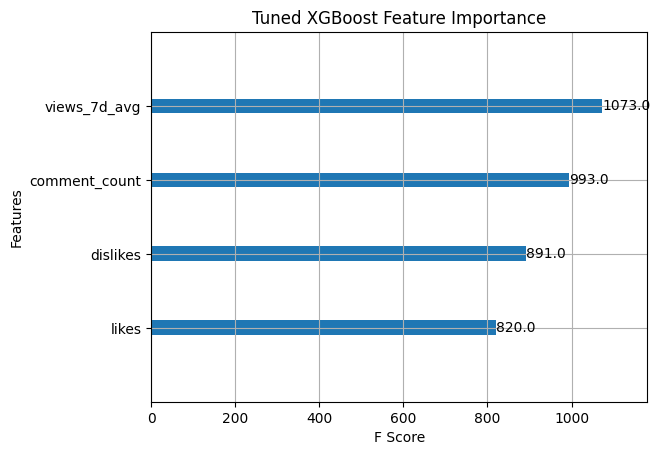

In [1634]:
# TUNED XGBOOST FEATURE IMPORTANCE PLOT

# Plot feature importance for the tuned XGBoost model
plot_importance(best_xgb_model, importance_type='weight')
plt.yticks(ticks=range(len(X_train.columns)), labels=X_train.columns)
plt.title('Tuned XGBoost Feature Importance')
plt.xlabel('F Score')
plt.ylabel('Features')
plt.show()  # Display the plot

##### Views 7-Day Average continues to be the most influential feature in predicting view count. After tuning, its importance slightly decreases, but it remains the strongest predictor of a video's future popularity. The difference between Views 7-Day Average and Comments increases after tuning, suggesting that the model places even more emphasis on Views 7-Day Average relative to Comments.
##### Comments show a decrease in importance after tuning. Although still a significant factor, their contribution to predicting views is slightly diminished in the tuned model compared to the untuned one. This shift indicates that while comments are still useful, the model now places relatively more importance on other features like Views 7-Day Average.
##### Dislikes see a notable decrease in importance after tuning. The gap between Comments and Dislikes narrows in the tuned model, suggesting that Dislikes become relatively less important, while Likes also take on a diminished role in comparison.
##### Likes experience a noticeable reduction in importance after tuning as well. This indicates that while Likes continue to contribute to predicting view count, their role becomes less significant after the model is fine-tuned. The model now shifts its focus toward other features like Dislikes and Comments, highlighting their growing influence.


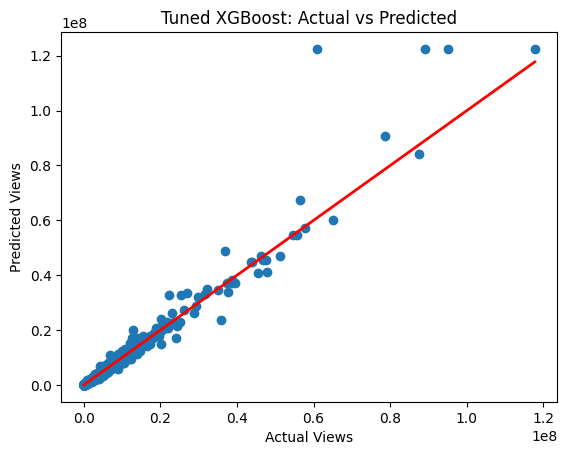

In [1636]:
# TUNED PREDICTED VS. ACTUAL FOR XGBOOST

# Recalculate predictions for tuned model
xg_pred_tuned = best_xgb_model.predict(X_test_scaled)

# Reprint Predicted vs Actual for tuned XGBoost
plt.scatter(y_test, xg_pred_tuned)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.title('Tuned XGBoost: Actual vs Predicted')
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.show()


In [1644]:
# TUNED VS UNTUNED MODEL COMPARISONS

# Create the comparison DataFrame with both tuned and untuned results
model_comparison_all = pd.DataFrame({
    'Model': ['Linear Regression (Untuned)', 'XGBoost (Untuned)', 
              'Linear Regression (Tuned)', 'XGBoost (Tuned)'],
    'MSE': [lr_mse, xg_mse, lr_mse_tuned, xg_mse_tuned],
    'R²': [lr_r2, xg_r2, lr_r2_tuned, xg_r2_tuned],
    'MAE': [lr_mae, xg_mae, lr_mae_tuned, xg_mae_tuned],
    'RMSE': [lr_rmse, xg_rmse, lr_rmse_tuned, xg_rmse_tuned]
})

model_comparison_all['MSE'] = model_comparison_all['MSE'].round(2)
model_comparison_all['MAE'] = model_comparison_all['MAE'].round(2)
model_comparison_all['RMSE'] = model_comparison_all['RMSE'].round(2)
model_comparison_all['R²'] = model_comparison_all['R²'].round(4)

# Print the comparison table
print(model_comparison_all)


                         Model           MSE      R²        MAE        RMSE
0  Linear Regression (Untuned)  1.189159e+12  0.9706  388334.55  1090485.61
1            XGBoost (Untuned)  2.147052e+12  0.9469  226711.32  1465282.35
2    Linear Regression (Tuned)  1.184549e+12  0.9707  387204.00  1088369.79
3              XGBoost (Tuned)  2.356840e+12  0.9417  252840.25  1535200.29


##### Linear Regression
###### Performance:  The untuned and tuned Linear Regression models show similar performance, with minimal improvements after tuning (Ridge regression). The MSE remains relatively high, and the R² values are almost identical, indicating no significant improvement in predictive accuracy. Despite tuning, the model still struggles with large errors, as seen in both the MAE and RMSE values. These metrics suggest that the model's predictions have considerable deviation from the actual values, reflecting poor predictive accuracy.
###### Limitations: Linear Regression assumes a linear relationship between the features and the target variable, which limits its ability to capture more complex, non-linear relationships in the data. In the case of viral YouTube videos, where trends can be highly volatile and non-linear, this assumption of linearity restricts the model’s performance. The lack of significant improvement after tuning further supports the notion that Linear Regression is not the most suitable model for this task.

##### XGBoost
###### Performance: XGBoost shows a modest improvement after tuning, with slightly lower MSE and a slightly higher R². However, even the untuned XGBoost model outperforms both the untuned and tuned Linear Regression models in terms of MSE, R², MAE, and RMSE. This suggests that XGBoost is better suited for capturing complex relationships in the data.
##### Strengths: XGBoost excels at modeling non-linear patterns and complex interactions between features, making it more effective at predicting viral spikes in views, where trends are often unpredictable and non-linear. The model’s ability to adapt to these complexities gives it an edge over Linear Regression, which is constrained by simpler assumptions.
###### Limitations: While XGBoost is effective at capturing non-linear relationships, the model is sensitive to hyperparameters and can be computationally expensive, especially on large datasets. It may also overfit, particularly when dealing with noisy or sparse data. Despite these limitations, XGBoost generally outperforms Linear Regression for this type of task, given its flexibility and ability to handle complex data patterns

##### Based on the analysis, Linear Regression achieves a higher R² and lower MSE, suggesting it explains the data better overall. However, XGBoost performs better in terms of MAE, indicating that its predictions are generally more accurate and with fewer large errors. While tuning does not drastically improve either model, XGBoost remains the more practical model for predicting viral YouTube views due to its ability to reduce larger errors in predictions.